In [2]:
import pickle

import numpy as np
import pandas as pd

from pathlib import Path

In [2]:
from ptls.preprocessing import PandasDataPreprocessor


libgomp: Invalid value for environment variable OMP_NUM_THREADS

libgomp: Invalid value for environment variable OMP_NUM_THREADS


In [3]:
from sklearn.model_selection import StratifiedKFold, train_test_split

In [4]:
MODEL_NAME='02_coles_orig'

for fold_i in [0,]:

    df_trx_pretrain = pd.read_pickle(f'data/fold_{fold_i}/df_trx_pretrain.pickle')
    df_seq_pretrain = pd.read_pickle(f'data/fold_{fold_i}/df_seq_pretrain.pickle')
    df_gbm_train = pd.read_pickle(f'data/fold_{fold_i}/df_gbm_train.pickle')
    df_gbm_test = pd.read_pickle(f'data/fold_{fold_i}/df_gbm_test.pickle')

    with open(f'data/fold_{fold_i}/pdp.pickle', 'rb') as f:
        pdp = pickle.load(f)
        
    break

In [5]:
import ptls.data_load
import ptls.data_load.datasets
import ptls.frames
import ptls.frames.coles
import ptls.frames.inference_module
import ptls.nn

In [6]:
import torch

In [7]:
from functools import partial

In [8]:
df_seq_pretrain_train, df_seq_pretrain_valid = train_test_split(
    df_seq_pretrain, test_size=0.05, shuffle=True, random_state=42)

In [9]:
len(df_seq_pretrain_train), len(df_seq_pretrain_valid)

(24700, 1300)

In [10]:
coles_data_module = ptls.frames.PtlsDataModule(
    train_data=ptls.frames.coles.ColesDataset(
        data=ptls.data_load.datasets.MemoryMapDataset(
            df_seq_pretrain_train.to_dict(orient='records') + 
            df_trx_pretrain.to_dict(orient='records')
        ),
        splitter=ptls.frames.coles.split_strategy.SampleSlices(
            split_count=5,
            cnt_min=25,
            cnt_max=200,
        ),
    ),
    valid_data=ptls.frames.coles.ColesDataset(
        data=ptls.data_load.datasets.MemoryMapDataset(
            df_seq_pretrain_train.to_dict(orient='records')),
        splitter=ptls.frames.coles.split_strategy.SampleSlices(
            split_count=5,
            cnt_min=25,
            cnt_max=100,
        ),
    ),
    train_batch_size=64,
    train_num_workers=4,
    valid_batch_size=650,
)

In [11]:
pl_coles_module = ptls.frames.coles.CoLESModule(
    validation_metric=ptls.frames.coles.metric.BatchRecallTopK(
        K=4,
        metric='cosine',
    ),
    seq_encoder=torch.nn.Sequential(
        ptls.nn.TrxEncoder(
            norm_embeddings=False,
            embeddings_noise=0.003,
            embeddings={
                'weekday': {'in': 10, 'out': 8},
                'small_group': {'in': 250, 'out': 16},
                'event_time': {'in': 800, 'out': 8},
            },
            numeric_values={ 
                # 'amount_rur': 'identity',
                'amount_rur': 'log',
            },
        ),
        ptls.nn.RnnEncoder(
            input_size=33,
            type='gru',
            hidden_size=800,
            is_reduce_sequence=True,
        ),
    ),
    head=ptls.nn.Head(use_norm_encoder=True),
    loss=ptls.frames.coles.losses.ContrastiveLoss(
        margin=0.5,
        sampling_strategy=ptls.frames.coles.sampling_strategies.HardNegativePairSelector(
          neg_count=5,
        ),
    ),
    optimizer_partial=partial(torch.optim.Adam, lr=0.001, weight_decay=0.0),
    lr_scheduler_partial=partial(torch.optim.lr_scheduler.StepLR, step_size=30, gamma=0.9025)
)

In [12]:
import pytorch_lightning as pl

In [13]:
trainer = pl.Trainer(
    gpus=1,
    max_epochs=150, # 150,
    enable_checkpointing=False,
    enable_progress_bar=False,
    gradient_clip_val=0.5,
    gradient_clip_algorithm="value",    
)   

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
pretrain_logger_version = trainer.logger.version
print(f'pretrain_logger_version = {pretrain_logger_version}')
trainer.fit(pl_coles_module, coles_data_module)

pretrain_logger_version = 54


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type            | Params
-------------------------------------------------------
0 | _loss              | ContrastiveLoss | 0     
1 | _seq_encoder       | Sequential      | 2.0 M 
2 | _validation_metric | BatchRecallTopK | 0     
3 | _head              | Head            | 0     
-------------------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.061     Total estimated model params size (MB)


In [ ]:
inference_dl_gbm_train = torch.utils.data.DataLoader(
    dataset=ptls.data_load.datasets.MemoryMapDataset(
        df_gbm_train.to_dict(orient='records'),
        i_filters=[
            ptls.data_load.iterable_processing.ISeqLenLimit(max_seq_len=2000), 
        ],
    ),
    collate_fn=ptls.data_load.utils.collate_feature_dict,
    shuffle=False,
    batch_size=1000,
    num_workers=12,
)

inference_dl_gbm_test = torch.utils.data.DataLoader(
    dataset=ptls.data_load.datasets.MemoryMapDataset(
        df_gbm_test.to_dict(orient='records'),
        i_filters=[
            ptls.data_load.iterable_processing.ISeqLenLimit(max_seq_len=2000), 
        ],
    ),
    collate_fn=ptls.data_load.utils.collate_feature_dict,
    shuffle=False,
    batch_size=1000,
    num_workers=12,
)

In [ ]:
inf_model = ptls.frames.inference_module.InferenceModule(
    model=pl_coles_module.seq_encoder, pandas_output=True, model_out_name='emb')

In [ ]:
predict_gbm_train = pl.Trainer(gpus=1, enable_progress_bar=False, logger=None)\
.predict(inf_model, inference_dl_gbm_train)

In [ ]:
predict_gbm_test = pl.Trainer(gpus=1, enable_progress_bar=False, logger=None)\
.predict(inf_model, inference_dl_gbm_test)

In [ ]:
predict_gbm_train = pd.concat(predict_gbm_train, axis=0)

In [ ]:
predict_gbm_test = pd.concat(predict_gbm_test, axis=0)

In [ ]:
predict_gbm_train.set_index('client_id', inplace=True)
predict_gbm_test.set_index('client_id', inplace=True)

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

In [ ]:
gbm_model = LGBMClassifier(**{
      'n_estimators': 1000,
      'boosting_type': 'gbdt',
      'objective': 'multiclass',
      'num_class': 4,
      'metric': 'multi_error',
      'learning_rate': 0.02,
      'subsample': 0.75,
      'subsample_freq': 1,
      'feature_fraction': 0.75,
      'colsample_bytree': None,
      'max_depth': 12,
      'lambda_l1': 1,
      'reg_alpha': None,
      'lambda_l2': 1,
      'reg_lambda': None,
      'min_data_in_leaf': 50,
      'min_child_samples': None,
      'num_leaves': 50,
      'random_state': 42,
      'n_jobs': 4,
})

In [ ]:
gbm_model.fit(predict_gbm_train.drop(columns='bins'), predict_gbm_train['bins'])

In [ ]:
acc = accuracy_score(
    gbm_model.predict(predict_gbm_test.drop(columns='bins')), 
    predict_gbm_test['bins'],
)
acc

In [ ]:
import datetime

In [ ]:
with open('results.log', 'at') as f:
    print('\t'.join([
        MODEL_NAME,
        f'{datetime.datetime.now():%Y-%m-%d %H:%M:%S}',
        f'{fold_i}',
        'accuracy',
        f'{acc:.4f}',
        f'{pretrain_logger_version}',
]), file=f)

In [8]:
df_res = pd.read_csv(
    'results.log', sep='\t', header=None,
    names=['model', 'time', 'fold_i', 'metric', 'value', 'pretrain_logger_version']
)
df_res.tail(10)

,model,time,fold_i,metric,value,pretrain_logger_version
8,02_coles_orig,2024-01-19 12:03:27,2,accuracy,0.6358,56
9,02_coles_orig,2024-01-19 12:03:33,4,accuracy,0.6340,58
10,04_coles_seqpretrain,2024-01-30 11:43:59,0,accuracy,0.6347,160
11,04_coles,2024-01-30 13:01:42,0,accuracy,0.6423,159
12,04_coles_seqpretrain,2024-01-30 14:22:25,1,accuracy,0.6452,161
13,04_coles,2024-01-30 16:57:44,1,accuracy,0.6437,162
14,04_coles_seqpretrain,2024-01-30 17:00:40,2,accuracy,0.6250,163
15,04_coles_seqpretrain,2024-01-30 19:39:08,3,accuracy,0.6345,165
16,04_coles,2024-01-30 20:53:53,2,accuracy,0.6365,164
17,04_coles_seqpretrain,2024-01-30 22:22:23,4,accuracy,0.6237,166


In [9]:
df_res.groupby('model')['value'].agg(['mean', 'std', lambda x: sorted(x)])

,mean,std,<lambda_0>
model,,,
02_agg_baseline,0.632480,0.003163,"[0.629, 0.6297, 0.6325, 0.635, 0.6362]"
02_coles_orig,0.639380,0.004827,"[0.634, 0.6358, 0.6387, 0.6427, 0.6457]"
04_coles,0.640833,0.003818,"[0.6365, 0.6423, 0.6437]"
04_coles_seqpretrain,0.632620,0.008714,"[0.6237, 0.625, 0.6345, 0.6347, 0.6452]"


In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

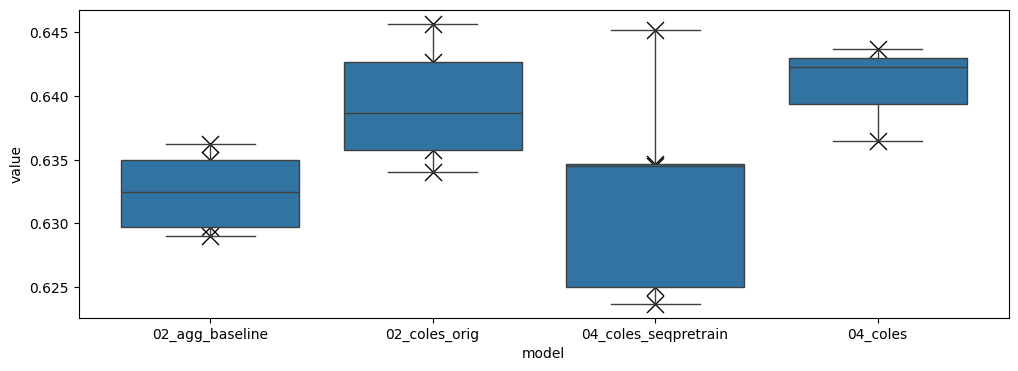

In [11]:
_, ax = plt.subplots(1, 1, figsize=(12, 4))
sns.boxplot(
    data=df_res,
    x='model',
    y='value',
)
sns.scatterplot(
    data=df_res,
    x='model',
    y='value',
    marker="x",
    c='k',
    s=150,
)

plt.show()